In [27]:
import numpy as np
import pandas as pd
import gc
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from tqdm import tqdm
import tensorflow as tf
from tensorflow.keras import layers
import tensorflow.keras.backend as K

print("Using Tensorflow {}".format(tf.__version__))
physical_devices = tf.config.experimental.list_physical_devices('GPU')
print("{} GPUs found".format(len(physical_devices)))
tf.config.experimental.set_memory_growth(physical_devices[0], True)
print("Using {}".format(physical_devices[0]))

tf.random.set_seed(1234)

Using Tensorflow 2.1.0
1 GPUs found
Using PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')


In [28]:
DEBUG = True

In [29]:
# Network hyperparameters from arXiv:1903.02433

# Training
BATCH_SIZE = 256
EPOCHS = 1000 # 500000 in paper

# Optimizer
LEARNING_RATE = 1e-5
BETA_1 = 0.5
BETA_2 = 0.9

# Architecture
NOISE_DIM = 128

# Plotting
PREFIX = "img/{:.0f}D-{}batchsize-".format(NOISE_DIM, BATCH_SIZE)

In [30]:
filenames = {
    "herwig": "Herwig_qcd_features.h5",
    "pythiabg": "events_anomalydetection_DelphesPythia8_v2_qcd_features.h5",
    "pythiasig": "events_anomalydetection_DelphesPythia8_v2_Wprime_features.h5"
}

datatypes = ["herwig", "pythiabg", "pythiasig"]

train_features = ["ptj1", "etaj1", "mj1", "tau21j1", "ptj2", "etaj2", "phij2", "mj2", "tau21j2"]
#condition_features = ["mjj"]

In [31]:
def load_data(datatype, stop = None, rotate = True, flip_eta = True):
    input_frame = pd.read_hdf(filenames[datatype], stop = stop)
    output_frame = pd.DataFrame(dtype = "float32")

    for jet in ["j1", "j2"]:
        output_frame["pt" + jet] = np.sqrt(input_frame["px" + jet]**2 + input_frame["py" + jet]**2)
        output_frame["eta" + jet] = np.arcsinh(input_frame["pz" + jet] / output_frame["pt" + jet])
        output_frame["phi" + jet] = np.arctan2(input_frame["py" + jet], input_frame["px" + jet])
        output_frame["m" + jet] = input_frame["m" + jet]
        output_frame["p" + jet] = np.sqrt(input_frame["pz" + jet]**2 + output_frame["pt" + jet]**2)
        output_frame["e" + jet] = np.sqrt(output_frame["m" + jet]**2 + output_frame["p" + jet]**2)
        output_frame["tau21" + jet] = input_frame["tau2" + jet] / input_frame["tau1" + jet]
        output_frame["tau32" + jet] = input_frame["tau3" + jet] / input_frame["tau2" + jet]
    
    del input_frame
    gc.collect()

    # Not exact rotation, since negative angles for phi2 are flipped across the x-axis. Should be OK due to symmetry.
    if rotate:
        output_frame["phij2"] = np.abs(output_frame["phij2"] - output_frame["phij1"])
        output_frame["phij1"] = 0
    
    if flip_eta:
        flipped_frame = output_frame.copy()
        flipped_frame["etaj1"] *= -1
        flipped_frame["etaj2"] *= -1
        output_frame = output_frame.append(flipped_frame)
        del flipped_frame
        gc.collect()
    
    for jet in ["j1", "j2"]:
        output_frame["px" + jet] = output_frame["pt" + jet] * np.cos(output_frame["phi" + jet])
        output_frame["py" + jet] = output_frame["pt" + jet] * np.sin(output_frame["phi" + jet])
        output_frame["pz" + jet] = output_frame["pt" + jet] * np.sinh(output_frame["eta" + jet])
    
    # Dijet properties
    output_frame["pxjj"] = output_frame["pxj1"] + output_frame["pxj2"]
    output_frame["pyjj"] = output_frame["pyj1"] + output_frame["pyj2"]
    output_frame["pzjj"] = output_frame["pzj1"] + output_frame["pzj2"]
    output_frame["ejj"] = output_frame["ej1"] + output_frame["ej2"]
    output_frame["pjj"] = np.sqrt(output_frame["pxjj"]**2 + output_frame["pyjj"]**2 + output_frame["pzjj"]**2)
    output_frame["mjj"] = np.sqrt(output_frame["ejj"]**2 - output_frame["pjj"]**2)

    # NaNs may arise from overly sparse jets with tau1 = 0, tau2 = 0, etc.
    output_frame.dropna(inplace = True)
    output_frame.reset_index(drop = True, inplace = True)
    
    return output_frame.astype('float32')

In [32]:
if DEBUG:
    df = load_data("pythiabg")
else:
    df = load_data("pythiabg")

In [33]:
# Ensures all batches have same size

df.drop([i for i in range(df.shape[0] % (BATCH_SIZE * 4))], inplace = True)
df.reset_index(drop = True, inplace = True)

# Normalize all inputs between -1 and 1

scaler = MinMaxScaler((-1,1)).fit(df[train_features])
feature_df = scaler.transform(df[train_features])

X_train, X_test = train_test_split(feature_df, test_size = 0.25, random_state = 1234)
len_dataset = int(X_train.shape[0] / BATCH_SIZE)
len_testset = int(X_test.shape[0] / BATCH_SIZE)
print("Dataset consists of {} batches of {} samples each, total {} samples".format(len_dataset, BATCH_SIZE, len_dataset * BATCH_SIZE))
print("Testset consists of {} batches of {} samples each, total {} samples".format(len_testset, BATCH_SIZE, len_testset * BATCH_SIZE))

del df
gc.collect()

Dataset consists of 732 batches of 2048 samples each, total 1499136 samples
Testset consists of 244 batches of 2048 samples each, total 499712 samples


0

In [34]:
train_dataset = tf.data.Dataset.from_tensor_slices(np.array(X_train)).batch(BATCH_SIZE)
test_dataset = tf.data.Dataset.from_tensor_slices(np.array(X_test)).batch(BATCH_SIZE)

In [35]:
def make_generator_model():
    model = tf.keras.Sequential()

    model.add(tf.keras.Input(shape = (NOISE_DIM,)))
    model.add(layers.Dense(128, kernel_initializer = 'glorot_uniform'))
    model.add(layers.LeakyReLU(alpha = 0.2))
    model.add(layers.BatchNormalization())
    
    model.add(layers.Reshape((8, 8, 2)))

    model.add(layers.Conv2DTranspose(32, kernel_size = 2, strides = 1, padding = "same"))
    model.add(layers.LeakyReLU(alpha = 0.2))
    model.add(layers.BatchNormalization())

    model.add(layers.Conv2DTranspose(16, kernel_size = 3, strides = 1, padding = "same"))
    model.add(layers.LeakyReLU(alpha = 0.2))
    model.add(layers.BatchNormalization())

    model.add(layers.Flatten())
    model.add(layers.Dense(len(train_features), activation = 'tanh'))

    return model

In [36]:
def make_discriminator_model():
    model = tf.keras.Sequential()

    model.add(tf.keras.Input(shape = (len(train_features),)))
    model.add(layers.Dense(128))    
    model.add(layers.Reshape((8, 8, 2)))

    model.add(layers.Conv2D(64, kernel_size = 3, strides = 1, padding = "same"))
    model.add(layers.LeakyReLU(alpha = 0.2))

    model.add(layers.Conv2D(32, kernel_size = 3, strides = 1, padding = "same"))
    model.add(layers.LeakyReLU(alpha = 0.2))

    model.add(layers.Conv2D(16, kernel_size = 3, strides = 1, padding = "same"))
    model.add(layers.LeakyReLU(alpha = 0.2))

    model.add(layers.Flatten())
    model.add(layers.LeakyReLU(alpha = 0.2))
    model.add(layers.Dropout(0.2))
    model.add(layers.Dense(1, activation = 'sigmoid'))

    return model

In [37]:
generator = make_generator_model()
generator.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_4 (Dense)              (None, 128)               16512     
_________________________________________________________________
leaky_re_lu_7 (LeakyReLU)    (None, 128)               0         
_________________________________________________________________
batch_normalization_3 (Batch (None, 128)               512       
_________________________________________________________________
reshape_2 (Reshape)          (None, 8, 8, 2)           0         
_________________________________________________________________
conv2d_transpose_2 (Conv2DTr (None, 8, 8, 32)          288       
_________________________________________________________________
leaky_re_lu_8 (LeakyReLU)    (None, 8, 8, 32)          0         
_________________________________________________________________
batch_normalization_4 (Batch (None, 8, 8, 32)         

In [38]:
discriminator = make_discriminator_model()
discriminator.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_6 (Dense)              (None, 128)               1280      
_________________________________________________________________
reshape_3 (Reshape)          (None, 8, 8, 2)           0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 8, 8, 64)          1216      
_________________________________________________________________
leaky_re_lu_10 (LeakyReLU)   (None, 8, 8, 64)          0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 8, 8, 32)          18464     
_________________________________________________________________
leaky_re_lu_11 (LeakyReLU)   (None, 8, 8, 32)          0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 8, 8, 16)         

In [39]:
mse = tf.keras.losses.MeanSquaredError()
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits = True)

In [40]:
@tf.function
def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss

In [41]:
@tf.function
def generator_loss(fake_output):
    return mse(tf.ones_like(fake_output), fake_output)

In [42]:
generator_optimizer = tf.keras.optimizers.Adam(learning_rate=LEARNING_RATE, beta_1=BETA_1, beta_2=BETA_2)
discriminator_optimizer = tf.keras.optimizers.Adam(learning_rate=LEARNING_RATE, beta_1=BETA_1, beta_2=BETA_2)

In [43]:
# Convert tensor to float for loss function plotting
def K_eval(x):
    try:
        return K.get_value(K.to_dense(x))
    except:
        eval_fn = K.function([], [x])
        return eval_fn([])[0]

In [44]:
@tf.function
def train_step_generator():
  gen_input = tf.random.uniform([BATCH_SIZE, NOISE_DIM])

  with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
    generated_vector = generator(gen_input, training=True)
    fake_output = discriminator(generated_vector, training=True)
    gen_loss = generator_loss(fake_output)

  gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)

  generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
  
  return gen_loss

In [45]:
@tf.function
def train_step_discriminator(vectors):
  gen_input = tf.random.uniform([BATCH_SIZE, NOISE_DIM])

  with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
    generated_vector = generator(gen_input, training=True)

    real_output = discriminator(vectors, training=True)
    fake_output = discriminator(generated_vector, training=True)
    
    disc_loss = discriminator_loss(real_output, fake_output)

  gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

  discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))
  
  return disc_loss

In [46]:
@tf.function
def evaluate_generator():
  gen_input = tf.random.uniform([BATCH_SIZE, NOISE_DIM])

  with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
    generated_vector = generator(gen_input, training=False)
    fake_output = discriminator(generated_vector, training=False)
    gen_loss = generator_loss(fake_output)
  
  return gen_loss

In [47]:
@tf.function
def evaluate_discriminator(vectors):
  gen_input = tf.random.uniform([BATCH_SIZE, NOISE_DIM])

  with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
    generated_vector = generator(gen_input, training=False)

    real_output = discriminator(vectors, training=False)
    fake_output = discriminator(generated_vector, training=False)
    
    disc_loss = discriminator_loss(real_output, fake_output)
  
  return disc_loss

In [48]:
def graph_gan(generator, epoch):
    plt.clf()

    realdata = scaler.inverse_transform(X_train)
    fakedata = scaler.inverse_transform(generator(tf.random.uniform((10000, NOISE_DIM)), training=False))
    
    f, a = plt.subplots(2, 2, constrained_layout=True)

    f.suptitle("GAN Generation")
    label = "Herwig Background"

    a[0, 0].set_title("Leading Jet Mass")
    a[0, 0].set_ylabel("Normalized to Unity")
    a[0, 0].set_xlabel("$m_{J_1}$")
    a[0, 0].hist(realdata[:,2], bins = 25, range = (0, 600), color = "tab:orange", alpha = 0.5, label = label, density = True)
    a[0, 0].hist(fakedata[:,2], bins = 25, range = (0, 600), color = "tab:blue", histtype = "step", label = "GAN", density = True)

    a[0, 1].set_title("Subleading Jet Mass")
    a[0, 1].set_ylabel("Normalized to Unity")
    a[0, 1].set_xlabel("$m_{J_2}$")
    a[0, 1].hist(realdata[:,7], bins = 25, range = (0, 600), color = "tab:orange", alpha = 0.5, label = label, density = True)
    a[0, 1].hist(fakedata[:,7], bins = 25, range = (0, 600), color = "tab:blue", histtype = "step", label = "GAN", density = True)
    a[0, 1].legend(loc="upper right")

    a[1, 0].set_title("Leading N-subjettiness ratio")
    a[1, 0].set_ylabel("Normalized to Unity")
    a[1, 0].set_xlabel("$\\tau_{21J_1}$")
    a[1, 0].hist(realdata[:,3], bins = 25, range = (0, 1), color = "tab:orange", alpha = 0.5, label = label, density = True)
    a[1, 0].hist(fakedata[:,3], bins = 25, range = (0, 1), color = "tab:blue", histtype = "step", label = "GAN", density = True)
    
    a[1, 1].set_title("Subleading N-subjettiness ratio")
    a[1, 1].set_ylabel("Normalized to Unity")
    a[1, 1].set_xlabel("$\\tau_{21J_2}$")
    a[1, 1].hist(realdata[:,8], bins = 25, range = (0, 1), color = "tab:orange", alpha = 0.5, label = label, density = True)
    a[1, 1].hist(fakedata[:,8], bins = 25, range = (0, 1), color = "tab:blue", histtype = "step", label = "GAN", density = True)

    if DEBUG:
        plt.show()
    else:
        plt.show()


In [49]:
train_gen_losses = []
train_disc_losses = []
test_gen_losses = []
test_disc_losses = []

In [50]:
def graph_losses(epoch):
    plt.clf()

    f, (ax1, ax2) = plt.subplots(2, 1, constrained_layout=True)

    f.suptitle("Loss Functions")

    ax1.set_title("Generator Loss")
    ax1.set_ylabel("Wasserstein Loss")
    ax1.set_xlabel("Epoch")
    ax1.plot(train_gen_losses, 'b', label = "Training loss")
    ax1.plot(test_gen_losses, 'r', label = "Validation loss")
    ax1.legend(loc="upper right")

    ax2.set_title("Discriminator Loss")
    ax2.set_ylabel("Wasserstein Loss")
    ax2.set_xlabel("Epoch")
    ax2.plot(train_disc_losses, 'b', label = "Training loss")
    ax2.plot(test_disc_losses, 'r', label = "Validation loss")

    if DEBUG:
        plt.show()
    else:
        plt.savefig("{}epoch{}-loss.png".format(PREFIX, epoch))

In [53]:
def train(dataset, testset, epochs):
    for epoch in tqdm(range(epochs)):
        print_losses = False #((epoch + 1) % 1 == 0)
        draw_outputs = ((epoch + 1) % 10== 0)

        train_gen_loss = 0
        train_disc_loss = 0

        test_gen_loss = 0
        test_disc_loss = 0

        # Training

        for batchnum, image_batch in enumerate(dataset):
            train_disc_loss += K_eval(train_step_discriminator(image_batch)) / len_dataset
            train_gen_loss += K_eval(train_step_generator()) / len_dataset


        train_gen_losses.append(train_gen_loss)
        train_disc_losses.append(train_disc_loss)

        # Evaluation

        for batchnum, test_batch in enumerate(testset):
            test_gen_loss += K_eval(evaluate_generator()) / len_testset
            test_disc_loss += K_eval(evaluate_discriminator(test_batch)) / len_testset

        test_gen_losses.append(test_gen_loss)
        test_disc_losses.append(test_disc_loss)

        # Logging

        if print_losses:
            print()
            print("Epoch " + str(epoch + 1) + ":")
            print()
            print("Generator training loss: " + str(train_gen_losses[-1]))
            print("Discriminator training loss: " + str(train_disc_losses[-1]))
            print()
            print("Generator validation loss: " + str(test_gen_losses[-1]))
            print("Discriminator validation loss: " + str(test_disc_losses[-1]))

        if draw_outputs:
            print()
            print("Epoch " + str(epoch + 1) + ":")
            graph_gan(generator, epoch + 1)
            graph_losses(epoch + 1)

  1%|▋                                                                              | 9/1000 [05:24<9:52:49, 35.89s/it]


Epoch 10:


<Figure size 432x288 with 0 Axes>

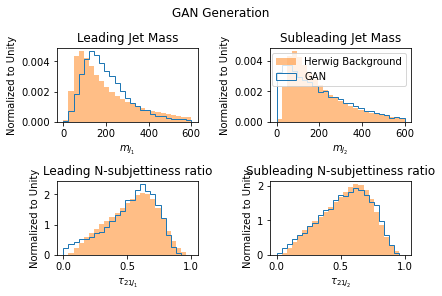

<Figure size 432x288 with 0 Axes>

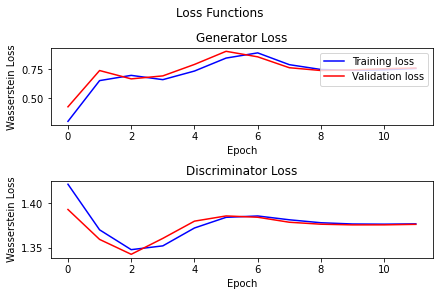

  2%|█▍                                                                            | 19/1000 [11:25<9:50:40, 36.13s/it]


Epoch 20:


<Figure size 432x288 with 0 Axes>

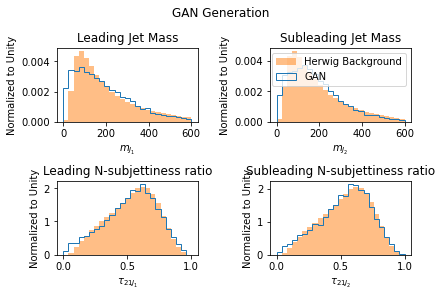

<Figure size 432x288 with 0 Axes>

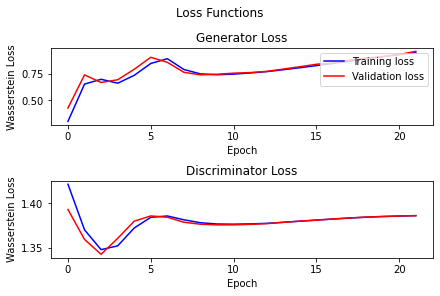

  3%|██▎                                                                           | 29/1000 [17:29<9:47:23, 36.30s/it]


Epoch 30:


<Figure size 432x288 with 0 Axes>

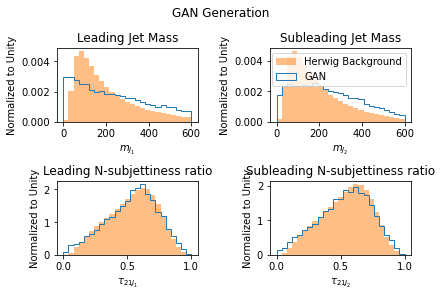

<Figure size 432x288 with 0 Axes>

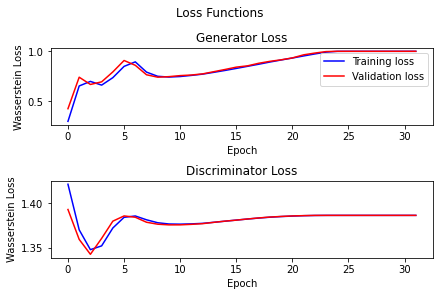

  4%|███                                                                           | 39/1000 [23:31<9:43:47, 36.45s/it]


Epoch 40:


<Figure size 432x288 with 0 Axes>

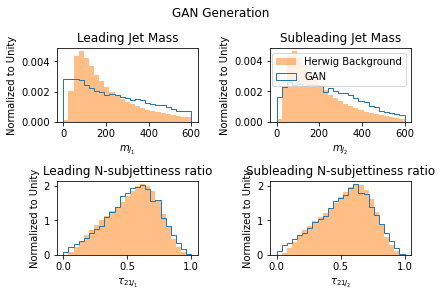

<Figure size 432x288 with 0 Axes>

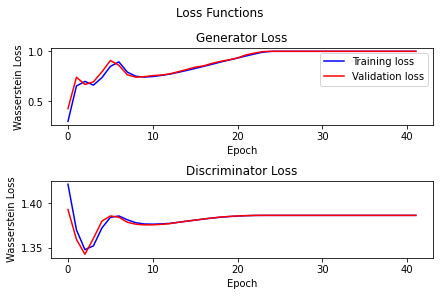

  5%|███▊                                                                          | 49/1000 [29:35<9:38:21, 36.49s/it]


Epoch 50:


<Figure size 432x288 with 0 Axes>

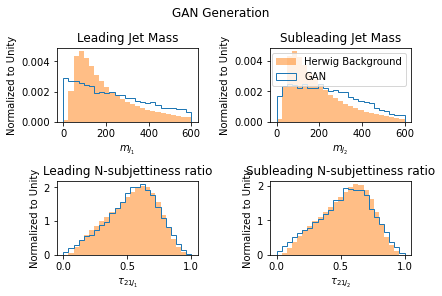

<Figure size 432x288 with 0 Axes>

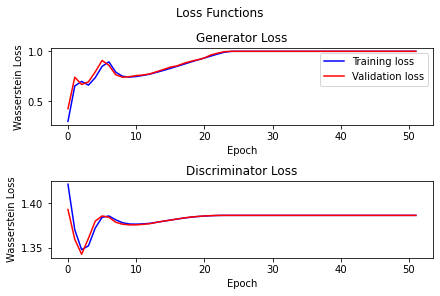

  6%|████▌                                                                         | 59/1000 [35:37<9:24:27, 35.99s/it]


Epoch 60:


<Figure size 432x288 with 0 Axes>

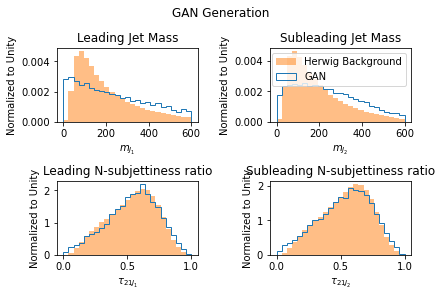

<Figure size 432x288 with 0 Axes>

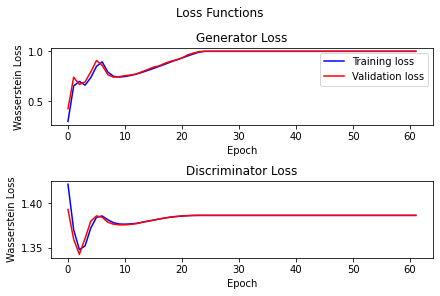

  7%|█████▍                                                                        | 69/1000 [41:37<9:15:16, 35.79s/it]


Epoch 70:


<Figure size 432x288 with 0 Axes>

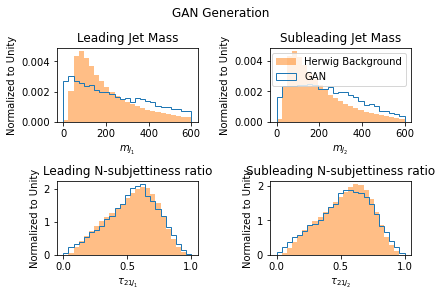

<Figure size 432x288 with 0 Axes>

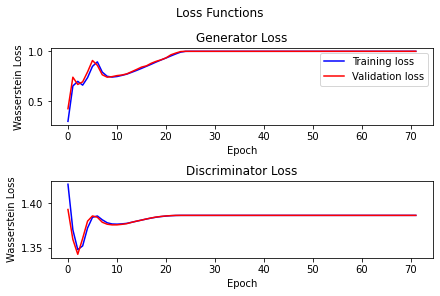

  8%|██████▏                                                                       | 79/1000 [47:41<9:15:26, 36.18s/it]


Epoch 80:


<Figure size 432x288 with 0 Axes>

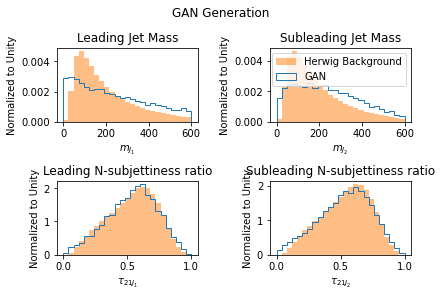

<Figure size 432x288 with 0 Axes>

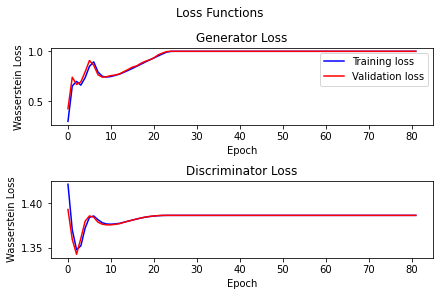

  9%|██████▉                                                                       | 89/1000 [53:41<9:04:54, 35.89s/it]


Epoch 90:


<Figure size 432x288 with 0 Axes>

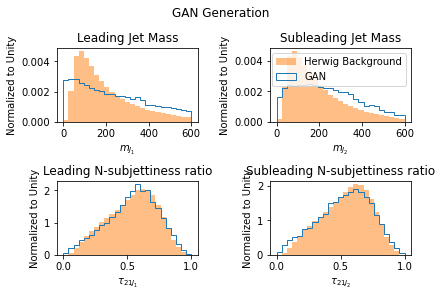

<Figure size 432x288 with 0 Axes>

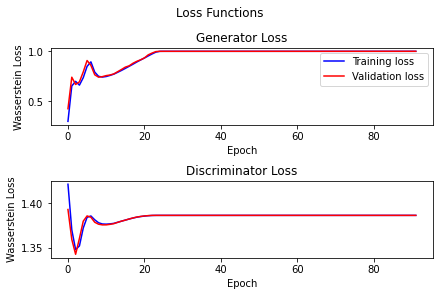

 10%|███████▋                                                                      | 99/1000 [59:42<9:02:01, 36.09s/it]


Epoch 100:


<Figure size 432x288 with 0 Axes>

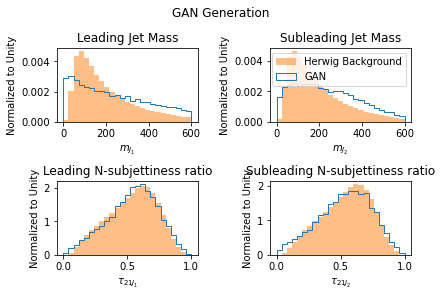

<Figure size 432x288 with 0 Axes>

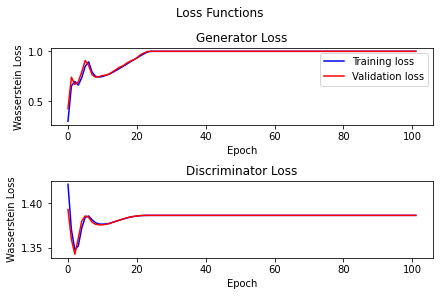

 11%|████████▏                                                                  | 109/1000 [1:05:43<8:54:04, 35.96s/it]


Epoch 110:


<Figure size 432x288 with 0 Axes>

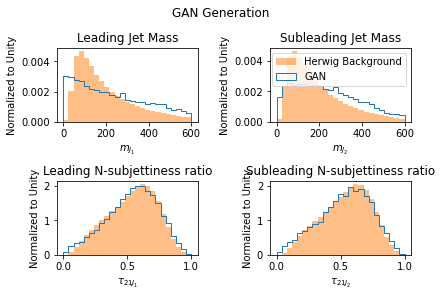

<Figure size 432x288 with 0 Axes>

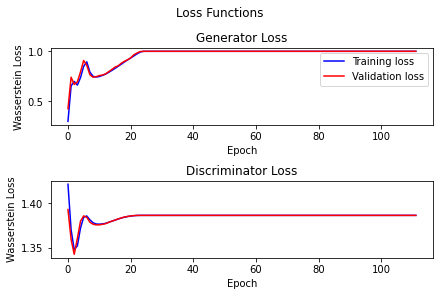

 12%|████████▉                                                                  | 119/1000 [1:11:45<8:52:26, 36.26s/it]


Epoch 120:


<Figure size 432x288 with 0 Axes>

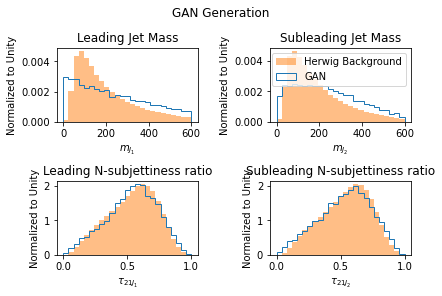

<Figure size 432x288 with 0 Axes>

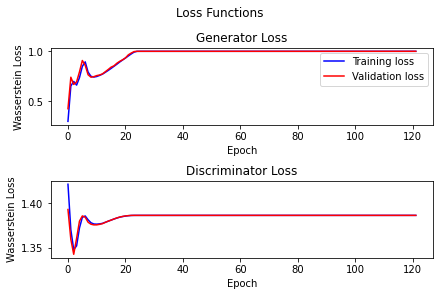

 13%|█████████▋                                                                 | 129/1000 [1:17:48<8:45:31, 36.20s/it]


Epoch 130:


<Figure size 432x288 with 0 Axes>

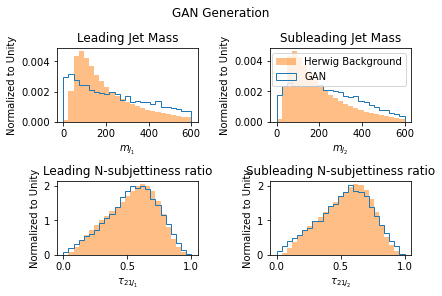

<Figure size 432x288 with 0 Axes>

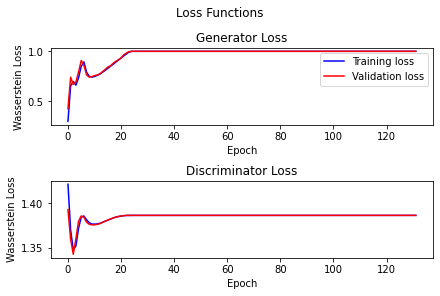

 14%|██████████▍                                                                | 139/1000 [1:23:50<8:36:18, 35.98s/it]


Epoch 140:


<Figure size 432x288 with 0 Axes>

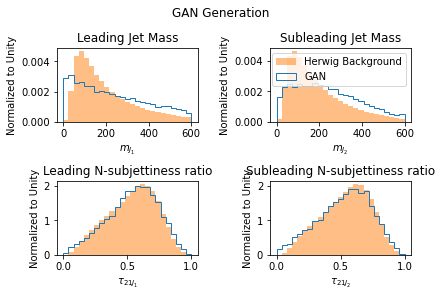

<Figure size 432x288 with 0 Axes>

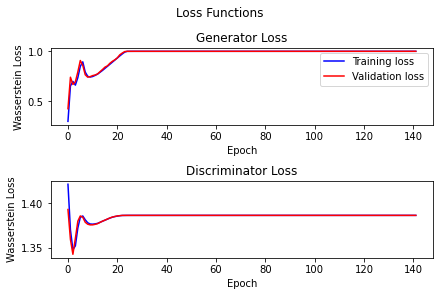

 15%|███████████▏                                                               | 149/1000 [1:29:50<8:28:55, 35.88s/it]


Epoch 150:


<Figure size 432x288 with 0 Axes>

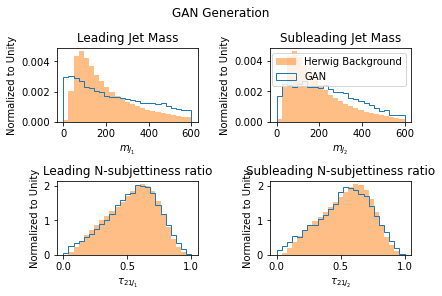

<Figure size 432x288 with 0 Axes>

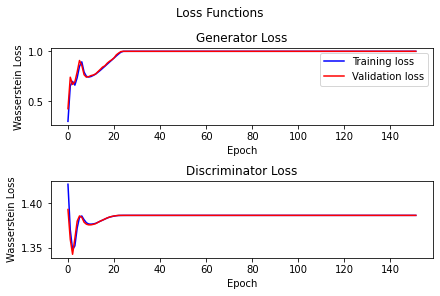

 16%|███████████▉                                                               | 159/1000 [1:35:49<8:22:50, 35.87s/it]


Epoch 160:


<Figure size 432x288 with 0 Axes>

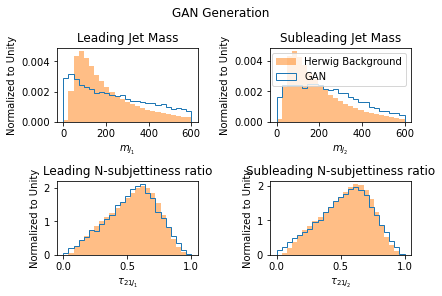

<Figure size 432x288 with 0 Axes>

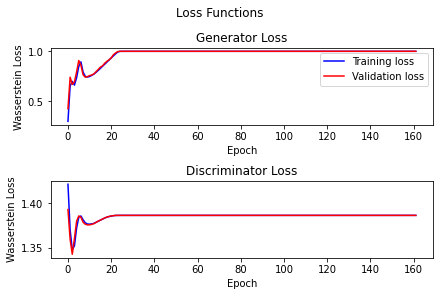

 17%|████████████▋                                                              | 169/1000 [1:41:54<8:22:33, 36.29s/it]


Epoch 170:


<Figure size 432x288 with 0 Axes>

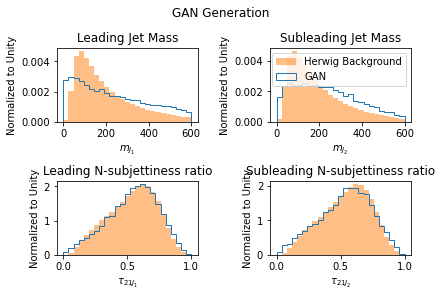

<Figure size 432x288 with 0 Axes>

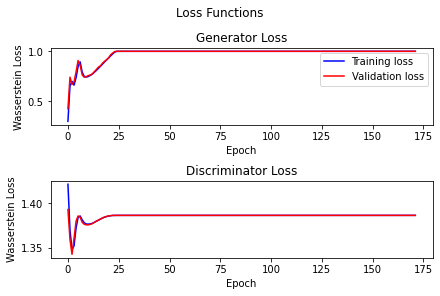

 18%|█████████████▍                                                             | 179/1000 [1:47:59<8:15:56, 36.24s/it]


Epoch 180:


<Figure size 432x288 with 0 Axes>

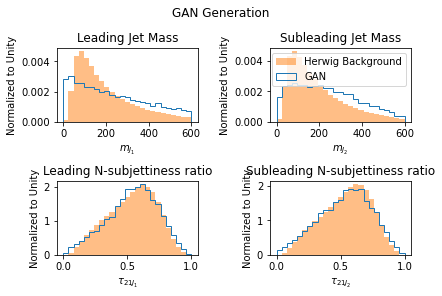

<Figure size 432x288 with 0 Axes>

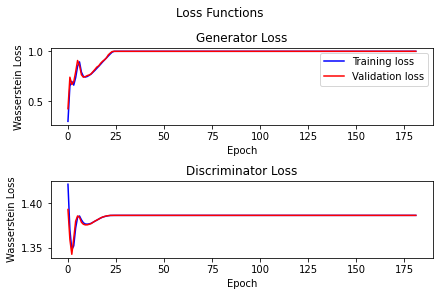

 19%|██████████████▏                                                            | 189/1000 [1:53:59<8:05:22, 35.91s/it]


Epoch 190:


<Figure size 432x288 with 0 Axes>

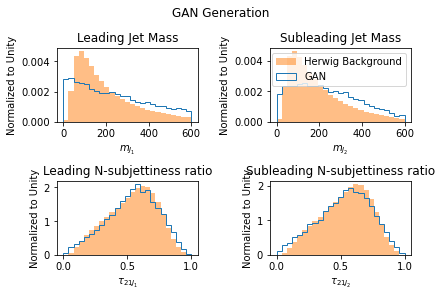

<Figure size 432x288 with 0 Axes>

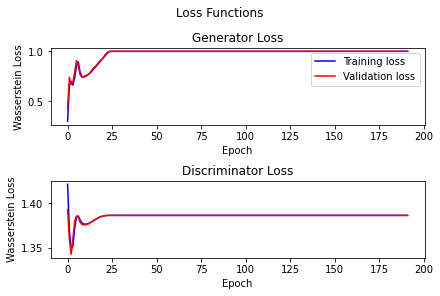

 20%|██████████████▉                                                            | 199/1000 [2:00:06<8:05:05, 36.34s/it]


Epoch 200:


<Figure size 432x288 with 0 Axes>

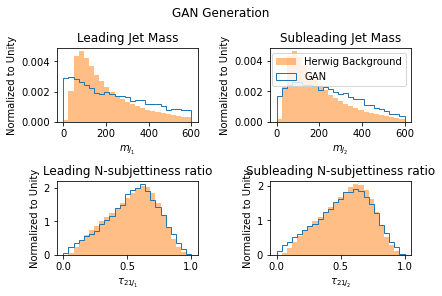

<Figure size 432x288 with 0 Axes>

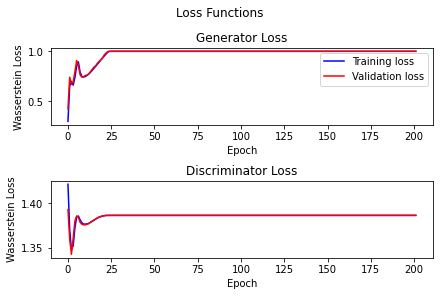

 21%|███████████████▋                                                           | 209/1000 [2:06:10<8:00:28, 36.45s/it]


Epoch 210:


<Figure size 432x288 with 0 Axes>

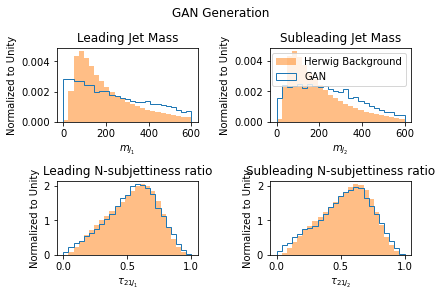

<Figure size 432x288 with 0 Axes>

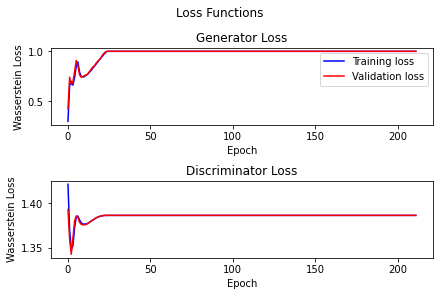

 22%|████████████████▍                                                          | 219/1000 [2:12:14<7:52:03, 36.27s/it]


Epoch 220:


<Figure size 432x288 with 0 Axes>

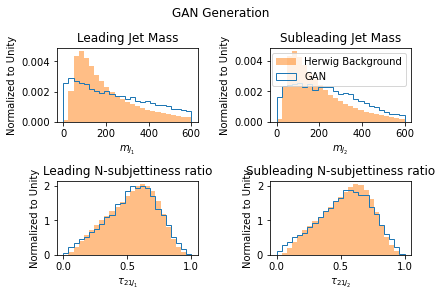

<Figure size 432x288 with 0 Axes>

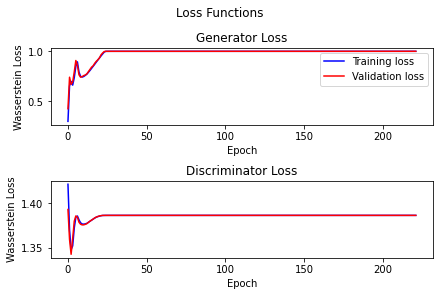

 23%|█████████████████▏                                                         | 229/1000 [2:18:14<7:41:36, 35.92s/it]


Epoch 230:


<Figure size 432x288 with 0 Axes>

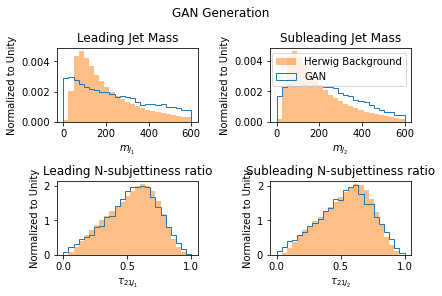

<Figure size 432x288 with 0 Axes>

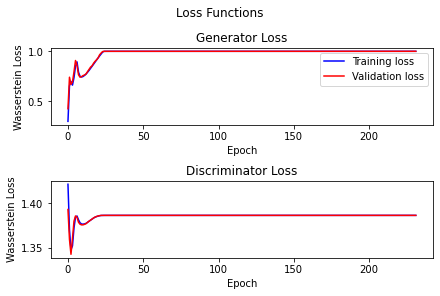

 24%|█████████████████▉                                                         | 239/1000 [2:24:30<7:53:42, 37.35s/it]


Epoch 240:


<Figure size 432x288 with 0 Axes>

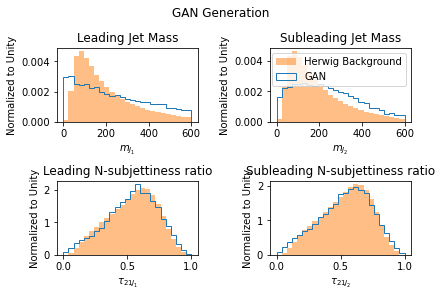

<Figure size 432x288 with 0 Axes>

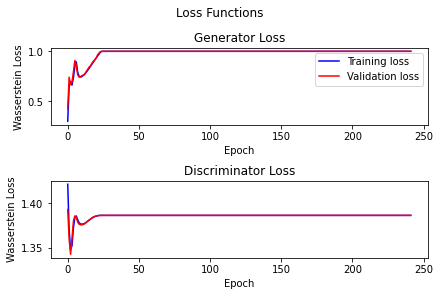

 25%|██████████████████▋                                                        | 249/1000 [2:30:37<7:38:43, 36.65s/it]


Epoch 250:


<Figure size 432x288 with 0 Axes>

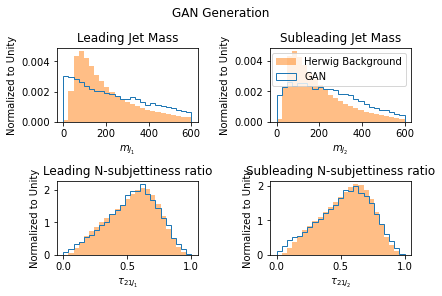

<Figure size 432x288 with 0 Axes>

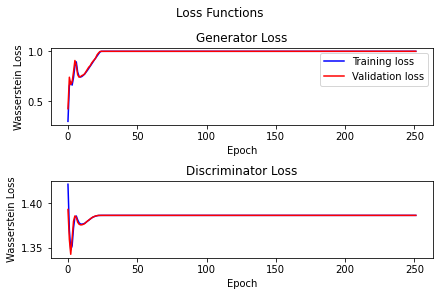

 26%|███████████████████▍                                                       | 259/1000 [2:36:55<7:52:47, 38.28s/it]


Epoch 260:


<Figure size 432x288 with 0 Axes>

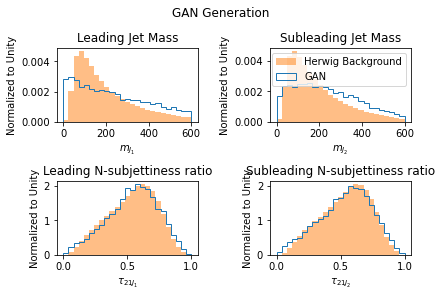

<Figure size 432x288 with 0 Axes>

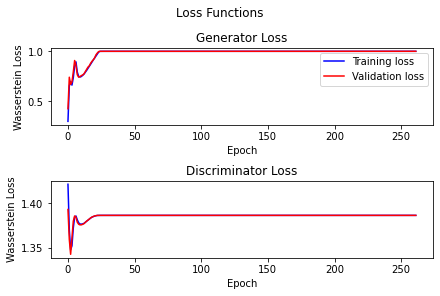

 27%|████████████████████▏                                                      | 269/1000 [2:43:13<7:34:50, 37.33s/it]


Epoch 270:


<Figure size 432x288 with 0 Axes>

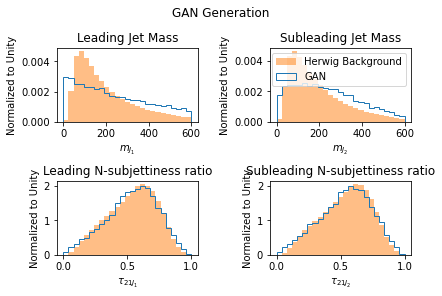

<Figure size 432x288 with 0 Axes>

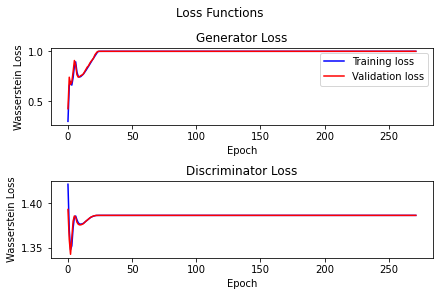

 28%|████████████████████▉                                                      | 279/1000 [2:49:18<7:17:05, 36.37s/it]


Epoch 280:


<Figure size 432x288 with 0 Axes>

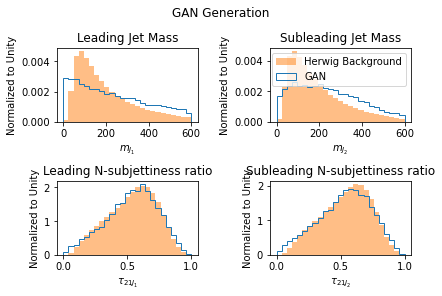

<Figure size 432x288 with 0 Axes>

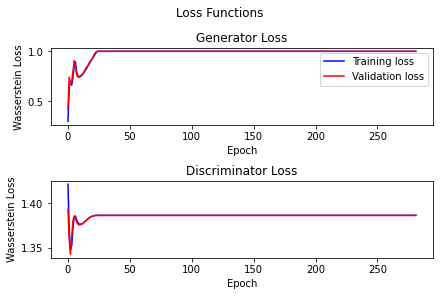

 29%|█████████████████████▋                                                     | 289/1000 [2:55:29<7:24:00, 37.47s/it]


Epoch 290:


<Figure size 432x288 with 0 Axes>

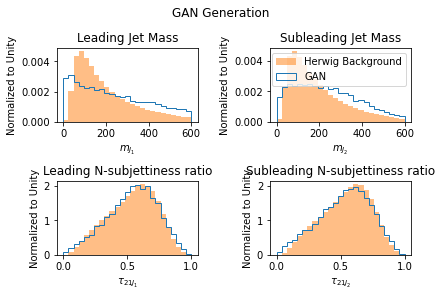

<Figure size 432x288 with 0 Axes>

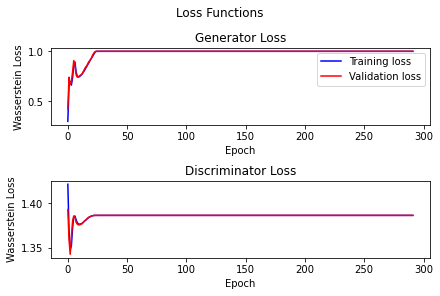

 30%|██████████████████████▍                                                    | 299/1000 [3:01:38<7:06:08, 36.47s/it]


Epoch 300:


<Figure size 432x288 with 0 Axes>

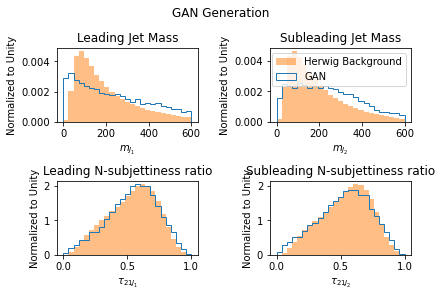

<Figure size 432x288 with 0 Axes>

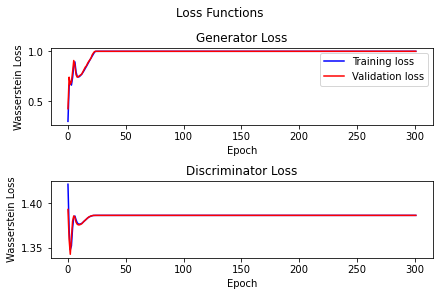

 30%|██████████████████████▌                                                    | 300/1000 [3:02:28<7:05:47, 36.50s/it]


KeyError: 'pop from an empty set'

In [54]:
train(train_dataset, test_dataset, EPOCHS)

<Figure size 432x288 with 0 Axes>

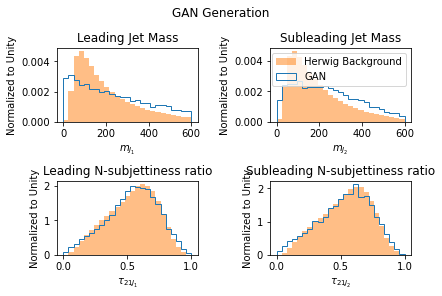

In [55]:
graph_gan(generator, 300)


In [56]:
def graph_gan(generator, epoch):
    plt.clf()

    realdata = scaler.inverse_transform(X_train)
    fakedata = scaler.inverse_transform(generator(tf.random.uniform((10000, NOISE_DIM)), training=False))
    
    f, a = plt.subplots(2, 2, constrained_layout=True)

    f.suptitle("GAN Generation")

    a[0, 0].set_title("Leading Jet Mass")
    a[0, 0].set_ylabel("Normalized to Unity")
    a[0, 0].set_xlabel("$m_{J_1}$")
    a[0, 0].hist(realdata[:,2], bins = 25, range = (0, 600), color = "tab:orange", alpha = 0.5, density = True)
    a[0, 0].hist(fakedata[:,2], bins = 25, range = (0, 600), color = "tab:blue", histtype = "step", density = True)

    a[0, 1].set_title("Subleading Jet Mass")
    a[0, 1].set_ylabel("Normalized to Unity")
    a[0, 1].set_xlabel("$m_{J_2}$")
    a[0, 1].hist(realdata[:,7], bins = 25, range = (0, 600), color = "tab:orange", alpha = 0.5,  density = True)
    a[0, 1].hist(fakedata[:,7], bins = 25, range = (0, 600), color = "tab:blue", histtype = "step",  density = True)
    a[0, 1].legend(loc="upper right")

    a[1, 0].set_title("Leading N-subjettiness ratio")
    a[1, 0].set_ylabel("Normalized to Unity")
    a[1, 0].set_xlabel("$\\tau_{21J_1}$")
    a[1, 0].hist(realdata[:,3], bins = 25, range = (0, 1), color = "tab:orange", alpha = 0.5,  density = True)
    a[1, 0].hist(fakedata[:,3], bins = 25, range = (0, 1), color = "tab:blue", histtype = "step", density = True)
    
    a[1, 1].set_title("Subleading N-subjettiness ratio")
    a[1, 1].set_ylabel("Normalized to Unity")
    a[1, 1].set_xlabel("$\\tau_{21J_2}$")
    a[1, 1].hist(realdata[:,8], bins = 25, range = (0, 1), color = "tab:orange", alpha = 0.5, density = True)
    a[1, 1].hist(fakedata[:,8], bins = 25, range = (0, 1), color = "tab:blue", histtype = "step", density = True)

    if DEBUG:
        plt.show()
    else:
        plt.show()


No handles with labels found to put in legend.


<Figure size 432x288 with 0 Axes>

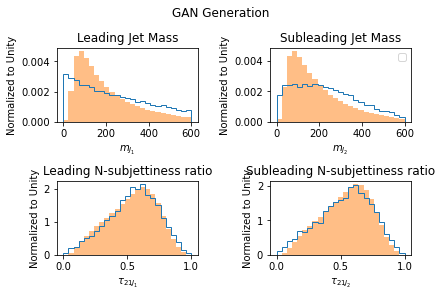

In [57]:
graph_gan(generator, 300)
